### What libraries can we import that we will need for later usage?

In [ ]:
#
import pandas as pd
from scipy.optimize import curve_fit
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
import scipy.stats as stats
#

Here a series of libraries were imported to DeepNote notebook. Though the DeepNote services may already have these services imported already, not only does doing so follow best practices, but it allows us to rename these libraries to something more familiar and easier to use.

### What datasets are we going to need to analyze this issue?

In [ ]:
electionData = pd.read_csv('election-data.csv')
stateName = pd.read_csv('state-abbreviation.csv')
usVacc = pd.read_csv('us_state_vaccinations.csv')

In analyzing the possible connection of political affiliation and vaccination status, three primary datasets, all CSV files, will be needed. The first file is a record of election data from the 2016 presidential election, categorized by state, sourced from NPR. The second file simply connects each state name with its codified two-letter abbreviation. The last file is a CSV file sourced from GitHub that has accumulated the daily vaccination statistics that each state has published. All three of these files are converted into DataFrames for later usage.

### How do we know that this data is usable?

In [ ]:
print(electionData.head(1))
print(stateName.head(1))
print(usVacc.head(1))

  State  Dems  Reps
0    AK    35    63
  US STATE ABBREVIATION
0  Alabama           AL
         date location  total_vaccinations  total_distributed  \
0  2021-01-12  Alabama             78134.0           377025.0   

   people_vaccinated  people_fully_vaccinated_per_hundred  \
0            70861.0                                 0.15   

   total_vaccinations_per_hundred  people_fully_vaccinated  \
0                            1.59                   7270.0   

   people_vaccinated_per_hundred  distributed_per_hundred  \
0                           1.45                     7.69   

   daily_vaccinations_raw  daily_vaccinations  daily_vaccinations_per_million  \
0                     NaN                 NaN                             NaN   

   share_doses_used  
0             0.207  


The .head() Pandas function is used here to confirm that the data is usable and there were no issues with reading in the data from the CSV files.

### How do we extract a specific vaccination metric from one state?

In [ ]:
def curve_plot(columnName, state):
    state_filter = usVacc[usVacc['location'] == state]
    state_filter.set_index('date')
    col_data = state_filter[columnName]
    # reset index
    col_data = col_data.reset_index(drop=True)
    col_data.dropna()
    return col_data

The curve_plot function was created to take the usVacc DataFrame, which contains all the data from the vaccination CSV file, and filter out data based upon a given state name input. From there, it creates a Pandas Series based upon the given name to select from the usVacc DataFrame. After resetting the index and dropping null values, it returns the series.

### How do we know that curve_plot is usable?

0        70861.0
1        74792.0
2        80480.0
3        86956.0
7       114319.0
         ...    
123    1697289.0
124    1699751.0
125    1699915.0
126    1709333.0
127    1709761.0
Name: people_vaccinated, Length: 124, dtype: float64


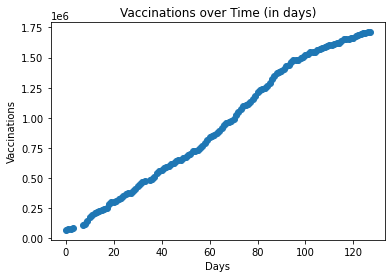

In [ ]:
# plot one such series as example
column = 'people_vaccinated'
state = 'Alabama'
curveSeries = curve_plot(column, state)

# Print out curveSeries to ensure that null values were dropped
curveSeries = curveSeries.dropna()
print(curveSeries)

plt.scatter(curveSeries.index, curveSeries)
plt.title('Vaccinations over Time (in days)')
plt.ylabel('Vaccinations')
plt.xlabel('Days')
plt.show()


The curve_plot function was tested by using Alabama's total vaccinated population as input variables. After using the scatter() method of pyplot and printing out the series, it can be confirmed that the curve_plot function works.

### Does the data fit a linear regression model?

In [ ]:
def curve_model(x, β0, β1, β2):
    return β0 / (1 + np.exp(β1*(-x + β2)))

def fit_data(curveInput):
    curveInput = curveInput.dropna()
    my_guessed_betas = [curveInput.max(), 1, (0.5*len(curveInput.index))]
    try:
        found_betas, covariance = curve_fit(curve_model,
            xdata=curveInput.index.values, ydata=curveInput.values,
            p0=my_guessed_betas)
        β0, β1, β2 = found_betas
    except TypeError:
        β0, β1, β2 = [np.nan, np.nan, np.nan]
    fit_model = lambda x: curve_model(x, β0, β1, β2)
    
    # If you want to ensure that the curve_fit model works
    
    # plt.plot(curveInput.index, curveInput)
    # plt.plot(curveInput.index, fit_model(curveInput.index))
    # plt.show()

    return β0, β1, β2

fit_data(curveSeries)

(1887331.3598205394, 0.03828467207246645, 64.88136758383932)

Two functions, curve_model and fit_data, were created. The latter was created to take in a Pandas series like the one created in curve_plot and return beta values based upon guesses it makes based upon the input data set. It uses a lambda function to create a function based upon the calculated betas, and the calculated betas are returned. For proof of functionality, code was dedicated to plotting graphing the function was included, but for efficiency purposes, it was commented out after functionality was proved in debugging. 

### How does this data correlate over each state?

In [ ]:
d = {'State':[], 'LTMaxVax':[], 'RateofVax':[], 'MaxDelta':[]}

for i in stateName['US STATE']:
    state_data = curve_plot('people_vaccinated_per_hundred', i)
    if len(state_data) > 0:
        state_betas = fit_data(state_data)
        β0, β1, β2 = state_betas
        d['State'].append(i)
        d['LTMaxVax'].append(β0)
        d['RateofVax'].append(β1)
        d['MaxDelta'].append(β2)    

In order to build a dataset based upon data from each state, a dictionary was created with columns to store values for the long-term maximum vaccinated population, the rate of vaccination for each day, and the time of maximum increase, as was the case when the fit_data function was tested with Alabama's data. Then, the state name column of stateName is iterated over the  'people_vaccinated_per_hundred' column of the usVacc DataFrame in order to store the beta values of each state in the dictionary just created.

### What correlations exist within the data?

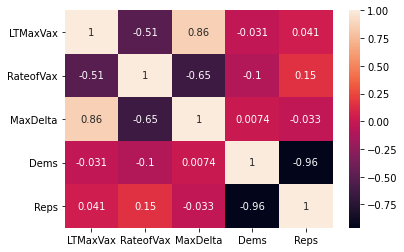

In [ ]:
df = pd.DataFrame(data=d)
df = df.merge(stateName, how='inner', left_on='State', right_on='US STATE')
df = df.merge(electionData, how='inner', left_on='ABBREVIATION', right_on='State')

numeric_columns_only = df.drop(['State_x', 'State_y', 'US STATE', 'ABBREVIATION'], axis=1)
correlation_coefficients = np.corrcoef(numeric_columns_only, rowvar=False)
sns.heatmap(correlation_coefficients, annot=True)
plt.xticks(np.arange(5)+0.5, numeric_columns_only.columns)
plt.yticks(np.arange(5)+0.5, numeric_columns_only.columns, rotation=0)
plt.show()

After the dictionary is created based upon each state's beta values, a DataFrame is created based upon the dictionary, and the DataFrame is merged with the numeric values from each of the three previously created DataFrames, being the voting statistics from electionData and the beta values previously input. Lastly, a correlation heat map is created using the heatmap function from the Seaborn library and the heat map is plotted for analysis.

### Are there any significant findings?

In [ ]:
α = 0.05

t_statistics, p_value = stats.ttest_ind(df['Reps'], df['Dems'])
reject_H0 = p_value < α
print(α, p_value, reject_H0)


0.05 0.038019344333197404 True


Based upon the data from the correlation heat map, a hypothesis test was constructed with a two-population sample to determine whether or not the difference in vaccination rates based upon political affiliation was statistically significant. Using a stored 5% confidence interval, the null hypothesis could be rejected as the calculated p-value was less than the confidence interval. 

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=677acccc-9fce-4b99-8d03-8f26079a07da' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>